# 3.1 Baseline Model (w/ Double Actuals)

In [1]:
#!pip install nibabel
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

In [3]:
# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

total_cases = len(images_paths_f_case) + len(images_paths_m_case)
total_controls = len(images_paths_f_control ) + len(images_paths_m_control)
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case))))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case))))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list - ORIGINAL
#images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

# ~triple female and ~1.5 male for 50 more female and 50 more male
images_paths_f_case_6 = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])[:6]
images_paths_m_case_50 = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])[:50]
images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control \
                + images_paths_f_case + images_paths_f_case + images_paths_f_case_6\
                + images_paths_m_case_50


num_im = len(images_paths)
image_array = []

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [4]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.asarray(image_array).astype('float32')

In [5]:
image_array.shape

(491, 61, 73, 61)

In [6]:
pheno = df[['FILE_ID', 'DX_GROUP']]
pheno_array = np.array(pheno['DX_GROUP'])
pheno_array = np.where(pheno_array == 2, 0, pheno_array)
# distribution
df['DX_GROUP'].value_counts()

2    245
1    146
Name: DX_GROUP, dtype: int64

In [7]:
# more pheno
more_pheno_cases = np.ones((100,), dtype=int)

# append to pheno_array
all_pheno = np.concatenate((pheno_array, more_pheno_cases))

In [8]:
more_pheno_cases

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
#training and holdout split
x_train, x_val, y_train, y_val = train_test_split(image_array, all_pheno, test_size = 0.15, random_state = 654)

#training and testing split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 654)

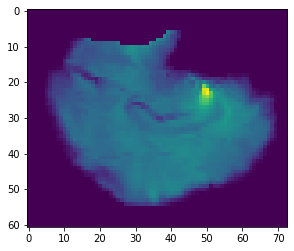

In [10]:
plt.imshow(x_train[0][30].T)

In [11]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-05 04:34:41.509605: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 04:34:43.225741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Architecture 

Define a 3D convolutional neural network
To make the model easier to understand, we structure it into blocks. The architecture of the 3D CNN used in this example is based on this paper.

In [12]:
def get_model(width=61, height=73, depth=61):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Normalization(axis=None)(inputs) #ADDED NORMALIZATION LAYER

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=16, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=61, height=73, depth=61)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 normalization (Normalizatio  (None, 61, 73, 61, 1)    3         
 n)                                                              
                                                                 
 conv3d (Conv3D)             (None, 61, 73, 61, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 36, 30, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 36, 30, 64)   256       
 ormalization)                                                   
                                                             

In [13]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# # Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "3d_image_classification_Cxa.h5", save_best_only=True
# )
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# # Train the model, doing validation at the end of each epoch
# epochs = 50
# model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=epochs,
#     shuffle=True,
#     verbose=2,
#     callbacks=[checkpoint_cb, early_stopping_cb],
# )

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping_cb],
)

Epoch 1/50


2022-05-05 04:34:47.148184: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-05 04:34:52.308629: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 - 12s - loss: 0.6646 - binary_accuracy: 0.6058 - auc: 0.6441 - val_loss: 0.7809 - val_binary_accuracy: 0.6381 - val_auc: 0.7286 - 12s/epoch - 1s/step
Epoch 2/50
10/10 - 1s - loss: 0.5773 - binary_accuracy: 0.7147 - auc: 0.7744 - val_loss: 0.9443 - val_binary_accuracy: 0.5333 - val_auc: 0.7233 - 1s/epoch - 129ms/step
Epoch 3/50
10/10 - 1s - loss: 0.5309 - binary_accuracy: 0.7308 - auc: 0.8080 - val_loss: 1.0434 - val_binary_accuracy: 0.4952 - val_auc: 0.7244 - 1s/epoch - 132ms/step
Epoch 4/50
10/10 - 1s - loss: 0.5131 - binary_accuracy: 0.7468 - auc: 0.8205 - val_loss: 1.0414 - val_binary_accuracy: 0.4571 - val_auc: 0.7336 - 1s/epoch - 129ms/step
Epoch 5/50
10/10 - 1s - loss: 0.4909 - binary_accuracy: 0.7628 - auc: 0.8440 - val_loss: 1.1781 - val_binary_accuracy: 0.4571 - val_auc: 0.7124 - 1s/epoch - 129ms/step
Epoch 6/50
10/10 - 1s - loss: 0.4842 - binary_accuracy: 0.7756 - auc: 0.8626 - val_loss: 1.0100 - val_binary_accuracy: 0.4571 - val_auc: 0.7114 - 1s/epoch - 127ms/step
Epoc

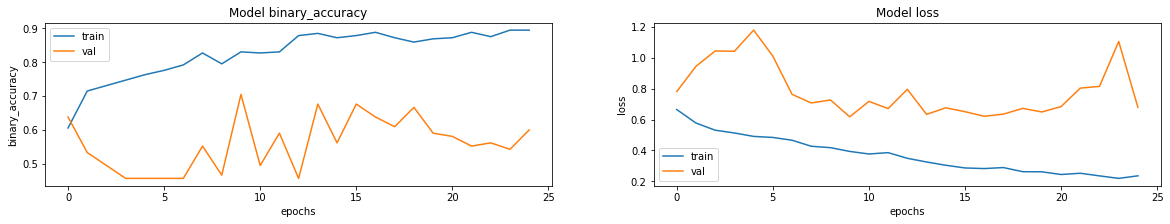

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

#for i, metric in enumerate(["auc_4", "loss"]):
for i, metric in enumerate(["binary_accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [15]:
# # Load best weights.
# model.load_weights("3d_image_classification_Cxa.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
print(y_test[0])

[0.38289398]
This model is 61.71 percent confident that CT scan is normal
This model is 38.29 percent confident that CT scan is abnormal
0


In [16]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 70ms/step - loss: 0.6306 - binary_accuracy: 0.6486 - auc: 0.7927


[0.630619466304779, 0.6486486196517944, 0.7926740050315857]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.80      0.34      0.48        35
           1       0.61      0.92      0.73        39

    accuracy                           0.65        74
   macro avg       0.71      0.63      0.61        74
weighted avg       0.70      0.65      0.61        74



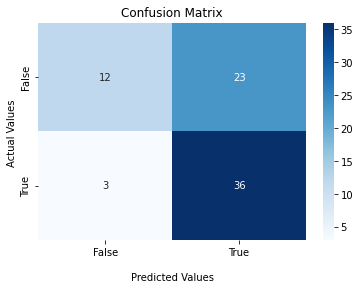

In [18]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [20]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [21]:
auc_keras

0.7912087912087912

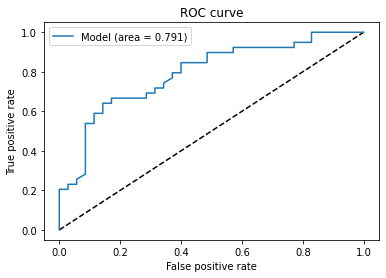

In [22]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()